### Antoine EDY
# Natural Language Processing (COMM061) - Coursework

In [92]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import nltk
from torch.utils.tensorboard import SummaryWriter

In [93]:
dataset = load_dataset("surrey-nlp/PLOD-CW")

In [94]:
def the_preprocess(df):
    df = pd.DataFrame(df)
    # make everything lowercase
    #df["tokens"] = df["tokens"].apply(lambda x: [i.lower() for i in x])
    # lematize
    lematizer = nltk.WordNetLemmatizer()
    df["tokens"] = df["tokens"].apply(lambda x: [lematizer.lemmatize(i) for i in x])
    #stemming
    #stemmer = nltk.PorterStemmer()
    #df["tokens"] = df["tokens"].apply(lambda x: [stemmer.stem(i) for i in x])

    return df

train_dataset = the_preprocess(dataset["train"])
test_dataset = the_preprocess(dataset["test"])
val_dataset = the_preprocess(dataset["validation"])

In [95]:
lematizer = nltk.WordNetLemmatizer()
sentence = "The striped bats are hanging on their feet for best"
sentence = sentence.split()
sentence = [lematizer.lemmatize(i) for i in sentence]
print(sentence)

['The', 'striped', 'bat', 'are', 'hanging', 'on', 'their', 'foot', 'for', 'best']


In [96]:
stemmer = nltk.PorterStemmer()
sentence = "The striped bats are hanging on their feet for best"
sentence = sentence.split()
sentence = [lematizer.lemmatize(i) for i in sentence]
sentence = [stemmer.stem(i) for i in sentence]
print(sentence)

['the', 'stripe', 'bat', 'are', 'hang', 'on', 'their', 'foot', 'for', 'best']


In [97]:
TEXT2ID = {
    "B-O": 0,
    "B-AC": 1,
    "PAD": 2,
    "B-LF": 3,
    "I-LF": 4,
}
ID2TEXT = {v: k for k, v in TEXT2ID.items()}

print(f"TEXT2ID: {TEXT2ID}\nID2TEXT: {ID2TEXT}\n")

def preprocess(df):
    df = df.drop(columns=['pos_tags'])
    df = df.rename(columns={"ner_tags": "labels"})
    df["ids"] = df["labels"].apply(lambda x: [TEXT2ID[i] for i in x])
    df["sentences"] = df["tokens"].apply(lambda x: " ".join(x))

    return df


train_dataset = preprocess(train_dataset)
test_dataset = preprocess(test_dataset)
val_dataset = preprocess(val_dataset)

train_dataset.info()


# Here the exploration to add at the end of the work.

TEXT2ID: {'B-O': 0, 'B-AC': 1, 'PAD': 2, 'B-LF': 3, 'I-LF': 4}
ID2TEXT: {0: 'B-O', 1: 'B-AC', 2: 'PAD', 3: 'B-LF', 4: 'I-LF'}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tokens     1072 non-null   object
 1   labels     1072 non-null   object
 2   ids        1072 non-null   object
 3   sentences  1072 non-null   object
dtypes: object(4)
memory usage: 33.6+ KB


In [98]:
train_dataset.head()

,tokens,labels,ids,sentences
0,"[For, this, purpose, the, Gothenburg, Young, P...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]",For this purpose the Gothenburg Young Persons ...
1,"[The, following, physiological, trait, were, m...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ...",The following physiological trait were measure...
2,"[Minor, H, antigen, alloimmune, response, read...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ...",Minor H antigen alloimmune response readily oc...
3,"[EPI, =, Echo, planar, imaging, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]","[1, 0, 3, 4, 4, 0]",EPI = Echo planar imaging .
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Furthermore , eNOS - derived NO S - nitrosylat..."


In [99]:
# distribution of labels
all_labels = [label for labels in train_dataset["labels"] for label in labels]

In [100]:
# plot the distribution of labels
print(f"Number of labels: {len(all_labels)}")
print(f"Number of unique labels: {len(set(all_labels))}")
print(f"Labels: {set(all_labels)}")

for i in set(all_labels):
    print(f"Number of {i}: {all_labels.count(i)}")

Number of labels: 40000
Number of unique labels: 4
Labels: {'I-LF', 'B-AC', 'B-LF', 'B-O'}
Number of I-LF: 3231
Number of B-AC: 2336
Number of B-LF: 1462
Number of B-O: 32971


In [101]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

1072
126
153


In [102]:
train_dataset.head()

,tokens,labels,ids,sentences
0,"[For, this, purpose, the, Gothenburg, Young, P...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]",For this purpose the Gothenburg Young Persons ...
1,"[The, following, physiological, trait, were, m...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ...",The following physiological trait were measure...
2,"[Minor, H, antigen, alloimmune, response, read...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ...",Minor H antigen alloimmune response readily oc...
3,"[EPI, =, Echo, planar, imaging, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]","[1, 0, 3, 4, 4, 0]",EPI = Echo planar imaging .
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Furthermore , eNOS - derived NO S - nitrosylat..."


In [103]:
from torchtext.data import Field, Dataset, Example

text_field = Field(sequential=True, tokenize=lambda x:x, include_lengths=True) # Default behaviour is to tokenize by splitting
label_field = Field(sequential=True, tokenize=lambda x:x, is_target=True)

fields = {
    'sentences': ('text', text_field),
    'ids': ('label', label_field)
}

def read_data(df):
    examples = []
    fields = {'sentence_labels': ('labels', label_field),
              'sentence_tokens': ('text', text_field)}
    
    for i in range(len(df)):
        tokens = df['tokens'][i]
        labels = df['labels'][i]
        
        e = Example.fromdict({"sentence_labels": labels, "sentence_tokens": tokens},
                             fields=fields)
        examples.append(e)
    
    return Dataset(examples, fields=[('labels', label_field), ('text', text_field)])


train_data = read_data(train_dataset)
val_data = read_data(val_dataset)
test_data = read_data(test_dataset)

print(train_data.fields)
print(train_data[0].text)
print(train_data[0].labels)

print("Train:", len(train_data))
print("Dev:", len(val_data))
print("Test:", len(test_data))

{'labels': <torchtext.data.field.Field object at 0x333ff80d0>, 'text': <torchtext.data.field.Field object at 0x333ff8070>}
['For', 'this', 'purpose', 'the', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', '(', 'GYPES', ')', 'wa', 'developed', '.']
['B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O']
Train: 1072
Dev: 126
Test: 153


In [104]:
VOCAB_SIZE = 20000

text_field.build_vocab(train_data, max_size=VOCAB_SIZE)
label_field.build_vocab(train_data)

In [105]:
from torchtext.data import BucketIterator

BATCH_SIZE = 16
train_iter = BucketIterator(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, 
                            sort_key=lambda x: len(x.text), sort_within_batch=True)
val_iter = BucketIterator(dataset=val_data, batch_size=BATCH_SIZE, 
                          sort_key=lambda x: len(x.text), sort_within_batch=True)
test_iter = BucketIterator(dataset=test_data, batch_size=BATCH_SIZE, 
                           sort_key=lambda x: len(x.text), sort_within_batch=True)

In [106]:
import random
import os
import numpy as np

emb = 'fasttext'

if emb == 'fasttext':

    EMBEDDING_PATH = "/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/code/data/cc.en.300.vec"

    def load_embeddings(path):
        """ Load the FastText embeddings from the embedding file. """
        print("Loading pre-trained embeddings")
        
        embeddings = {}
        with open(path) as i:
            for line in i:
                if len(line) > 2: 
                    line = line.strip().split()
                    word = line[0]
                    embedding = np.array(line[1:])
                    embeddings[word] = embedding
        
        return embeddings
        

    def initialize_embeddings(embeddings, vocabulary):
        """ Use the pre-trained embeddings to initialize an embedding matrix. """
        print("Initializing embedding matrix")
        embedding_size = len(embeddings["."])
        embedding_matrix = np.zeros((len(vocabulary), embedding_size), dtype=np.float32)
                                    
        for idx, word in enumerate(vocabulary.itos): 
            if word in embeddings:
                embedding_matrix[idx,:] = embeddings[word]
                
        return embedding_matrix

    embeddings = load_embeddings(EMBEDDING_PATH)
    embedding_matrix = initialize_embeddings(embeddings, text_field.vocab)
    embedding_matrix = torch.from_numpy(embedding_matrix)
    print(embedding_matrix.shape)

elif emb == 'glove':

    EMBEDDING_PATH = "data/glove.6B.300d.txt"

    def load_embeddings(path):
        """ Load the FastText embeddings from the embedding file. """
        print("Loading pre-trained embeddings")
        
        embeddings = {}
        with open(path) as i:
            for line in i:
                if len(line) > 2: 
                    line = line.strip().split()
                    word = line[0]
                    embedding = np.array(line[1:])
                    embeddings[word] = embedding
        
        return embeddings
        

    def initialize_embeddings(embeddings, vocabulary):
        """ Use the pre-trained embeddings to initialize an embedding matrix. """
        print("Initializing embedding matrix")
        embedding_size = len(embeddings["."])
        embedding_matrix = np.zeros((len(vocabulary), embedding_size), dtype=np.float32)
                                    
        for idx, word in enumerate(vocabulary.itos): 
            if word in embeddings:
                embedding_matrix[idx,:] = embeddings[word]
                
        return embedding_matrix

    embeddings = load_embeddings(EMBEDDING_PATH)
    embedding_matrix = initialize_embeddings(embeddings, text_field.vocab)
    embedding_matrix = torch.from_numpy(embedding_matrix)
    print(embedding_matrix.shape)


elif emb == 'word2vec':
    import gensim
    model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)
    em = []
    for word in text_field.vocab.itos:
        if word in model:
            em.append(model.get_vector(word))
        else:
            em.append(np.zeros(300))
    em = np.array(em)
    embedding_matrix = torch.tensor(em, dtype=torch.float32)
    print(embedding_matrix.shape)

Loading pre-trained embeddings
Initializing embedding matrix
torch.Size([8711, 300])


In [107]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()
        
        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)
        
        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=1)
        
        # 3. Optional dropout layer
        self.dropout_layer = nn.Dropout(p=0.5)

        # 4. Dense Layer
        self.hidden2tag = nn.Linear(2*hidden_dim, output_size)
        
    def forward(self, batch_text, batch_lengths):

        embeddings = self.embeddings(batch_text)
        
        packed_seqs = pack_padded_sequence(embeddings, batch_lengths)
        lstm_output, _ = self.lstm(packed_seqs)
        lstm_output, _ = pad_packed_sequence(lstm_output)
        lstm_output = self.dropout_layer(lstm_output)
        
        logits = self.hidden2tag(lstm_output)
        return logits

In [108]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, classification_report
from seqeval.metrics import f1_score as seqeval_f1_score

def remove_predictions_for_masked_items(predicted_labels, correct_labels): 

    predicted_labels_without_mask = []
    correct_labels_without_mask = []
        
    for p, c in zip(predicted_labels, correct_labels):
        if c > 1:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)
            
    return predicted_labels_without_mask, correct_labels_without_mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES}: {label_field.vocab.itos}")

def train(model, train_iter, dev_iter, batch_size, max_epochs, num_batches, patience, output_path):
    writer = SummaryWriter()

    # add weight to indexes 3, 4, 5
    w = [0, 0, 0.0443, 0.6259, 1.0000, 0.4525]
    class_weights = torch.tensor(w).to(device)
    criterion = nn.CrossEntropyLoss(weight = class_weights, ignore_index=1)  # we mask the <pad> labels
    # Hinge loss
    # criterion = nn.MultiMarginLoss(margin=1.0, weight=class_weights, reduction='mean')
    
    optimizer = optim.Adam(model.parameters())

    # SGD
    #lr = 0.1
    #optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # AdamW
    optimizer = optim.AdamW(model.parameters())

    train_f_score_history = []
    dev_f_score_history = []
    no_improvement = 0
    for epoch in range(max_epochs):

        total_loss = 0
        predictions, correct = [], []
        for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):
            optimizer.zero_grad()
            
            text_length, cur_batch_size = batch.text[0].shape
            
            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size*text_length)
            
            loss = criterion(pred, gold)
            
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, pred_indices = torch.max(pred, 1)
            
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        train_scores = precision_recall_fscore_support(correct, predictions, average="micro")
        train_f_score_history.append(train_scores[2])
            
        print("Total training loss:", total_loss)
        print("Training performance:", train_scores)

        #tensorboard
        writer.add_scalar('train/loss', total_loss, epoch)
        writer.add_scalar('train/precision', train_scores[2], epoch)

        
        total_loss = 0
        predictions, correct = [], []
        for batch in dev_iter:

            text_length, cur_batch_size = batch.text[0].shape

            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size * text_length)
            loss = criterion(pred, gold)
            total_loss += loss.item()

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        dev_scores = precision_recall_fscore_support(correct, predictions, average="micro")
            
        print("Total development loss:", total_loss)
        print("Development performance:", dev_scores)

        writer.add_scalar('val/loss', total_loss, epoch)
        writer.add_scalar('val/precision', dev_scores[2], epoch)


        labels = label_field.vocab.itos[2:]
        labels = sorted(labels, key=lambda x: x.split("-")[-1])
        label_idxs = [label_field.vocab.stoi[l] for l in labels]

        cr = classification_report(correct, predictions, labels = label_idxs, target_names=labels, output_dict=True)

        out = {}
        for key in cr.keys():
            if key == 'accuracy':
                out[key] = cr[key]
            else:
                for new_k in ['precision', 'recall', 'f1-score']:
                    out[key+'_'+new_k] = cr[key][new_k]
        
        for (key, value) in out.items():
            writer.add_scalar(f'test/{key}', value, epoch)

        t2id = ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']
        t2id= {i: t2id[i] for i in range(len(t2id))}


        correct = [t2id[i] for i in correct]
        predictions = [t2id[i] for i in predictions]

        # sequeval f1 score
        seqeval_f1 = seqeval_f1_score([correct], [predictions])
        print(seqeval_f1)
        writer.add_scalar('test/seqeval_f1', seqeval_f1, epoch)
        
        
        dev_f = dev_scores[2]

        dev_f = out['macro avg_f1-score']

        if len(dev_f_score_history) > patience and dev_f < max(dev_f_score_history):
            no_improvement += 1

        elif len(dev_f_score_history) == 0 or dev_f > max(dev_f_score_history):
            print("Saving model.")
            torch.save(model, output_path)
            no_improvement = 0
            
        if no_improvement > patience:
            print("Macro average F1-score does not improve anymore. Stop training.")
            dev_f_score_history.append(dev_f)
            break
            
        dev_f_score_history.append(dev_f)
        
    return train_f_score_history, dev_f_score_history

Number of classes: 6: ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


In [109]:
def test(model, test_iter, batch_size, labels, target_names): 
    
    total_loss = 0
    predictions, correct = [], []
    for batch in test_iter:

        text_length, cur_batch_size = batch.text[0].shape

        pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
        gold = batch.labels.to(device).view(cur_batch_size * text_length)

        _, pred_indices = torch.max(pred, 1)
        predicted_labels = list(pred_indices.cpu().numpy())
        correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())

        predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, correct_labels)

        predictions += predicted_labels
        correct += correct_labels
    print(labels, target_names)
    print(classification_report(correct, predictions, labels=labels, target_names=target_names))
    return correct, predictions

In [110]:
import math

EMBEDDING_DIM = 300 #fasttext & word2vec & glove
# EMBEDDING_DIM = 768 #bert
HIDDEN_DIM = 256
NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES} : {label_field.vocab.itos}")
MAX_EPOCHS = 50
PATIENCE = 50
OUTPUT_PATH = "model_saves/bilstmtagger"
num_batches = math.ceil(len(train_data) / BATCH_SIZE)

tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES, embeddings=embedding_matrix)  # embeddings
# tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES)  # no embeddings

train_f, dev_f = train(tagger.to(device), train_iter, val_iter, BATCH_SIZE, MAX_EPOCHS, num_batches, PATIENCE, OUTPUT_PATH)

Number of classes: 6 : ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


Epoch 0: 100%|██████████| 67/67 [00:05<00:00, 12.46it/s]


Total training loss: 63.26077550649643
Training performance: (0.4862, 0.4862, 0.4862, None)
Total development loss: 5.353721797466278
Development performance: (0.7894, 0.7894, 0.7894, None)
0.7991422444603288
Saving model.


Epoch 1: 100%|██████████| 67/67 [00:05<00:00, 12.10it/s]


Total training loss: 32.947170436382294
Training performance: (0.7666, 0.7666, 0.7666, None)
Total development loss: 4.511424273252487
Development performance: (0.7864, 0.7864, 0.7864, None)
0.7864870381710553
Saving model.


Epoch 2: 100%|██████████| 67/67 [00:05<00:00, 12.99it/s]


Total training loss: 26.912165269255638
Training performance: (0.794625, 0.794625, 0.794625, None)
Total development loss: 4.707223445177078
Development performance: (0.7116, 0.7116, 0.7116, None)
0.7163461538461539


Epoch 3: 100%|██████████| 67/67 [00:05<00:00, 12.43it/s]


Total training loss: 24.104160025715828
Training performance: (0.81045, 0.81045, 0.81045, None)
Total development loss: 3.7874752283096313
Development performance: (0.8034, 0.8034, 0.8034, None)
0.8039894158355384
Saving model.


Epoch 4: 100%|██████████| 67/67 [00:04<00:00, 13.90it/s]


Total training loss: 21.584134593605995
Training performance: (0.8206, 0.8206, 0.8206, None)
Total development loss: 3.8349757194519043
Development performance: (0.8686, 0.8686, 0.8686, None)
0.8692299888404179
Saving model.


Epoch 5: 100%|██████████| 67/67 [00:04<00:00, 14.16it/s]


Total training loss: 19.659873262047768
Training performance: (0.83895, 0.83895, 0.83895, None)
Total development loss: 3.760994464159012
Development performance: (0.8364, 0.8364, 0.8364, None)
0.8381573583367306


Epoch 6: 100%|██████████| 67/67 [00:05<00:00, 12.02it/s]


Total training loss: 18.05368785560131
Training performance: (0.84495, 0.84495, 0.84495, None)
Total development loss: 3.6418484151363373
Development performance: (0.8648, 0.8648, 0.8648, None)
0.8646403242147923
Saving model.


Epoch 7: 100%|██████████| 67/67 [00:05<00:00, 12.97it/s]


Total training loss: 16.657892420887947
Training performance: (0.8599, 0.8599, 0.8599, None)
Total development loss: 3.6886720955371857
Development performance: (0.8354, 0.8354, 0.8354, None)
0.837427377433493


Epoch 8: 100%|██████████| 67/67 [00:05<00:00, 13.32it/s]


Total training loss: 15.026858650147915
Training performance: (0.865775, 0.865775, 0.865775, None)
Total development loss: 3.5987507700920105
Development performance: (0.869, 0.869, 0.869, None)
0.8687379819856289
Saving model.


Epoch 9: 100%|██████████| 67/67 [00:04<00:00, 14.02it/s]


Total training loss: 13.926293309777975
Training performance: (0.875425, 0.875425, 0.875425, None)
Total development loss: 3.589682549238205
Development performance: (0.878, 0.878, 0.878, None)
0.8794814664776179
Saving model.


Epoch 10: 100%|██████████| 67/67 [00:05<00:00, 12.63it/s]


Total training loss: 12.04702865704894
Training performance: (0.888875, 0.888875, 0.888875, None)
Total development loss: 3.6454212367534637
Development performance: (0.8798, 0.8798, 0.8798, None)
0.8825371174628827
Saving model.


Epoch 11: 100%|██████████| 67/67 [00:06<00:00, 11.00it/s]


Total training loss: 11.83841958642006
Training performance: (0.890225, 0.890225, 0.890225, None)
Total development loss: 3.5881027579307556
Development performance: (0.8474, 0.8474, 0.8474, None)
0.8473197029803682


Epoch 12: 100%|██████████| 67/67 [00:06<00:00, 10.47it/s]


Total training loss: 11.35709297657013
Training performance: (0.890975, 0.890975, 0.890975, None)
Total development loss: 3.267711639404297
Development performance: (0.8316, 0.8316, 0.8316, None)
0.8311978848891601


Epoch 13: 100%|██████████| 67/67 [00:06<00:00, 11.15it/s]


Total training loss: 9.694937381893396
Training performance: (0.900475, 0.900475, 0.900475, None)
Total development loss: 4.0972470343112946
Development performance: (0.9022, 0.9022, 0.9022, None)
0.9037606146380914
Saving model.


Epoch 14: 100%|██████████| 67/67 [00:07<00:00,  9.41it/s]


Total training loss: 8.906925281509757
Training performance: (0.90795, 0.90795, 0.90795, None)
Total development loss: 3.9097849428653717
Development performance: (0.86, 0.86, 0.86, None)
0.8621772151898733


Epoch 15: 100%|██████████| 67/67 [00:05<00:00, 11.28it/s]


Total training loss: 8.319437187165022
Training performance: (0.91325, 0.91325, 0.91325, None)
Total development loss: 4.157689929008484
Development performance: (0.8966, 0.8966, 0.8966, None)
0.8985682597297842


Epoch 16: 100%|██████████| 67/67 [00:06<00:00, 10.55it/s]


Total training loss: 7.297322144731879
Training performance: (0.92255, 0.92255, 0.92255, None)
Total development loss: 5.226361840963364
Development performance: (0.9042, 0.9042, 0.9042, None)
0.9068548387096773


Epoch 17: 100%|██████████| 67/67 [00:06<00:00, 11.06it/s]


Total training loss: 6.606598619371653
Training performance: (0.92675, 0.92675, 0.92675, None)
Total development loss: 4.439548194408417
Development performance: (0.8972, 0.8972, 0.8972, None)
0.8991809080796845


Epoch 18: 100%|██████████| 67/67 [00:06<00:00, 11.00it/s]


Total training loss: 5.730214364826679
Training performance: (0.93755, 0.93755, 0.93755, None)
Total development loss: 4.3034204840660095
Development performance: (0.8822, 0.8822, 0.8822, None)
0.8845998383185126


Epoch 19: 100%|██████████| 67/67 [00:05<00:00, 11.18it/s]


Total training loss: 5.7025263626128435
Training performance: (0.9347, 0.9347, 0.9347, None)
Total development loss: 4.7531886994838715
Development performance: (0.8768, 0.8768, 0.8768, None)
0.8792231438397734


Epoch 20: 100%|██████████| 67/67 [00:06<00:00, 10.91it/s]


Total training loss: 5.353407255373895
Training performance: (0.936875, 0.936875, 0.936875, None)
Total development loss: 4.720050245523453
Development performance: (0.8784, 0.8784, 0.8784, None)
0.8804523424878836


Epoch 21: 100%|██████████| 67/67 [00:06<00:00, 11.10it/s]


Total training loss: 4.733441885560751
Training performance: (0.94365, 0.94365, 0.94365, None)
Total development loss: 5.132640898227692
Development performance: (0.8976, 0.8976, 0.8976, None)
0.899263890289402


Epoch 22: 100%|██████████| 67/67 [00:05<00:00, 11.28it/s]


Total training loss: 4.027688438072801
Training performance: (0.950875, 0.950875, 0.950875, None)
Total development loss: 5.398542433977127
Development performance: (0.9084, 0.9084, 0.9084, None)
0.9108691268400887
Saving model.


Epoch 23: 100%|██████████| 67/67 [00:06<00:00, 10.83it/s]


Total training loss: 3.641652592457831
Training performance: (0.955125, 0.955125, 0.955125, None)
Total development loss: 6.823206782341003
Development performance: (0.9096, 0.9096, 0.9096, None)
0.9126800282002215


Epoch 24: 100%|██████████| 67/67 [00:06<00:00, 10.80it/s]


Total training loss: 3.49512573517859
Training performance: (0.956775, 0.956775, 0.956775, None)
Total development loss: 6.071820914745331
Development performance: (0.9068, 0.9068, 0.9068, None)
0.9103003426728481


Epoch 25: 100%|██████████| 67/67 [00:06<00:00, 10.02it/s]


Total training loss: 3.279212689958513
Training performance: (0.959, 0.959, 0.959, None)
Total development loss: 5.283219486474991
Development performance: (0.8918, 0.8918, 0.8918, None)
0.8955705781454948


Epoch 26: 100%|██████████| 67/67 [00:06<00:00, 10.92it/s]


Total training loss: 3.1159295327961445
Training performance: (0.9605, 0.9605, 0.9605, None)
Total development loss: 6.826081693172455
Development performance: (0.908, 0.908, 0.908, None)
0.9113464447806354


Epoch 27: 100%|██████████| 67/67 [00:05<00:00, 11.40it/s]


Total training loss: 2.6531393602490425
Training performance: (0.966975, 0.966975, 0.966975, None)
Total development loss: 6.274446576833725
Development performance: (0.8874, 0.8874, 0.8874, None)
0.8892932969366091


Epoch 28: 100%|██████████| 67/67 [00:05<00:00, 11.95it/s]


Total training loss: 2.4874159251339734
Training performance: (0.967075, 0.967075, 0.967075, None)
Total development loss: 6.69719135761261
Development performance: (0.898, 0.898, 0.898, None)
0.9000505305709955


Epoch 29: 100%|██████████| 67/67 [00:05<00:00, 11.35it/s]


Total training loss: 2.2735987254418433
Training performance: (0.970725, 0.970725, 0.970725, None)
Total development loss: 7.705281019210815
Development performance: (0.9024, 0.9024, 0.9024, None)
0.9045063291139241


Epoch 30: 100%|██████████| 67/67 [00:05<00:00, 11.32it/s]


Total training loss: 1.7689491738565266
Training performance: (0.97505, 0.97505, 0.97505, None)
Total development loss: 8.117494195699692
Development performance: (0.9114, 0.9114, 0.9114, None)
0.9142742016722071


Epoch 31: 100%|██████████| 67/67 [00:05<00:00, 11.58it/s]


Total training loss: 1.796358520630747
Training performance: (0.975475, 0.975475, 0.975475, None)
Total development loss: 6.556844890117645
Development performance: (0.893, 0.893, 0.893, None)
0.8960920933050591


Epoch 32: 100%|██████████| 67/67 [00:06<00:00, 11.11it/s]


Total training loss: 1.9231445072218776
Training performance: (0.974275, 0.974275, 0.974275, None)
Total development loss: 8.779973208904266
Development performance: (0.9152, 0.9152, 0.9152, None)
0.9168765743073047


Epoch 33: 100%|██████████| 67/67 [00:05<00:00, 11.25it/s]


Total training loss: 1.856472146231681
Training performance: (0.97555, 0.97555, 0.97555, None)
Total development loss: 7.135223805904388
Development performance: (0.8938, 0.8938, 0.8938, None)
0.8957365124267529


Epoch 34: 100%|██████████| 67/67 [00:05<00:00, 11.22it/s]


Total training loss: 2.6320245284587145
Training performance: (0.968275, 0.968275, 0.968275, None)
Total development loss: 5.8025045692920685
Development performance: (0.88, 0.88, 0.88, None)
0.8818053025703297


Epoch 35: 100%|██████████| 67/67 [00:05<00:00, 11.23it/s]


Total training loss: 2.1329358057118952
Training performance: (0.97045, 0.97045, 0.97045, None)
Total development loss: 7.763892471790314
Development performance: (0.8926, 0.8926, 0.8926, None)
0.8928896530798018


Epoch 36: 100%|██████████| 67/67 [00:06<00:00, 11.06it/s]


Total training loss: 1.5342539884150028
Training performance: (0.979, 0.979, 0.979, None)
Total development loss: 9.69830584526062
Development performance: (0.9166, 0.9166, 0.9166, None)
0.9186901763224182


Epoch 37: 100%|██████████| 67/67 [00:06<00:00,  9.91it/s]


Total training loss: 1.2191324706654996
Training performance: (0.983075, 0.983075, 0.983075, None)
Total development loss: 8.304988026618958
Development performance: (0.9048, 0.9048, 0.9048, None)
0.9075698014313073


Epoch 38: 100%|██████████| 67/67 [00:06<00:00, 10.04it/s]


Total training loss: 1.1645954076666385
Training performance: (0.984175, 0.984175, 0.984175, None)
Total development loss: 9.085566878318787
Development performance: (0.9074, 0.9074, 0.9074, None)
0.9097516656571775


Epoch 39: 100%|██████████| 67/67 [00:06<00:00, 11.05it/s]


Total training loss: 0.8906466132029891
Training performance: (0.988225, 0.988225, 0.988225, None)
Total development loss: 10.028968840837479
Development performance: (0.9056, 0.9056, 0.9056, None)
0.9077899828680842


Epoch 40: 100%|██████████| 67/67 [00:06<00:00, 10.96it/s]


Total training loss: 0.9101039448287338
Training performance: (0.9872, 0.9872, 0.9872, None)
Total development loss: 10.032379746437073
Development performance: (0.9112, 0.9112, 0.9112, None)
0.9128680919725695


Epoch 41: 100%|██████████| 67/67 [00:06<00:00, 10.98it/s]


Total training loss: 1.6297410069964826
Training performance: (0.97885, 0.97885, 0.97885, None)
Total development loss: 9.079587042331696
Development performance: (0.9032, 0.9032, 0.9032, None)
0.9039045114303055


Epoch 42: 100%|██████████| 67/67 [00:06<00:00, 10.96it/s]


Total training loss: 1.8897826126776636
Training performance: (0.974975, 0.974975, 0.974975, None)
Total development loss: 9.176207482814789
Development performance: (0.9034, 0.9034, 0.9034, None)
0.904819520064529


Epoch 43: 100%|██████████| 67/67 [00:06<00:00, 10.74it/s]


Total training loss: 1.3236659585963935
Training performance: (0.98125, 0.98125, 0.98125, None)
Total development loss: 8.889537155628204
Development performance: (0.9114, 0.9114, 0.9114, None)
0.9143203148652739


Epoch 44: 100%|██████████| 67/67 [00:05<00:00, 11.44it/s]


Total training loss: 1.7763117670547217
Training performance: (0.9758, 0.9758, 0.9758, None)
Total development loss: 8.261759012937546
Development performance: (0.8836, 0.8836, 0.8836, None)
0.8850539913210212


Epoch 45: 100%|██████████| 67/67 [00:05<00:00, 11.30it/s]


Total training loss: 1.176408905070275
Training performance: (0.984225, 0.984225, 0.984225, None)
Total development loss: 9.417749851942062
Development performance: (0.9086, 0.9086, 0.9086, None)
0.9101203113941968


Epoch 46: 100%|██████████| 67/67 [00:06<00:00, 10.73it/s]


Total training loss: 0.7984778080135584
Training performance: (0.989, 0.989, 0.989, None)
Total development loss: 10.638656854629517
Development performance: (0.9094, 0.9094, 0.9094, None)
0.9123903619316464


Epoch 47: 100%|██████████| 67/67 [00:06<00:00, 10.28it/s]


Total training loss: 0.6538043753243983
Training performance: (0.9908, 0.9908, 0.9908, None)
Total development loss: 10.07671332359314
Development performance: (0.9074, 0.9074, 0.9074, None)
0.9095487510072522


Epoch 48: 100%|██████████| 67/67 [00:07<00:00,  9.32it/s]


Total training loss: 0.5883473311550915
Training performance: (0.991725, 0.991725, 0.991725, None)
Total development loss: 10.846032917499542
Development performance: (0.9068, 0.9068, 0.9068, None)
0.9091275844679778


Epoch 49: 100%|██████████| 67/67 [00:06<00:00, 10.61it/s]


Total training loss: 0.505340272677131
Training performance: (0.99235, 0.99235, 0.99235, None)
Total development loss: 12.694384098052979
Development performance: (0.9056, 0.9056, 0.9056, None)
0.9077498231787411


In [111]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

# Data
#df = pd.DataFrame({'epochs': range(0,len(train_f)), 'train_f': train_f, 'val_f': dev_f})
 
# multiple line plot
#plt.plot('epochs', 'train_f', data=df, color='blue', linewidth=2)
#plt.plot('epochs', 'val_f', data=df, color='green', linewidth=2)
#plt.legend()
#plt.show()


In [112]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [118]:
OUTPUT_PATH = "model_saves/fasttext_lem"

In [119]:
tagger = torch.load(OUTPUT_PATH)
tagger.eval()

BiLSTMTagger(
  (embeddings): Embedding(8711, 300)
  (lstm): LSTM(300, 256, bidirectional=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (hidden2tag): Linear(in_features=512, out_features=6, bias=True)
)

In [120]:
labels = label_field.vocab.itos[2:]
labels = sorted(labels, key=lambda x: x.split("-")[-1])
label_idxs = [label_field.vocab.stoi[l] for l in labels]

c, p = test(tagger, test_iter, BATCH_SIZE, labels = label_idxs, target_names = labels)
labels, target_names = [4, 3, 5, 2], ['B-AC', 'I-LF', 'B-LF', 'B-O']

ID2TEXT = dict()
for i in range(len(labels)):
    ID2TEXT[labels[i]] = target_names[i]

c = [ID2TEXT[i] for i in c]
p = [ID2TEXT[i] for i in p]

[4, 3, 5, 2] ['B-AC', 'I-LF', 'B-LF', 'B-O']
              precision    recall  f1-score   support

        B-AC       0.53      0.70      0.61       270
        I-LF       0.64      0.84      0.73       288
        B-LF       0.54      0.66      0.59       150
         B-O       0.97      0.92      0.95      4292

    accuracy                           0.90      5000
   macro avg       0.67      0.78      0.72      5000
weighted avg       0.92      0.90      0.91      5000



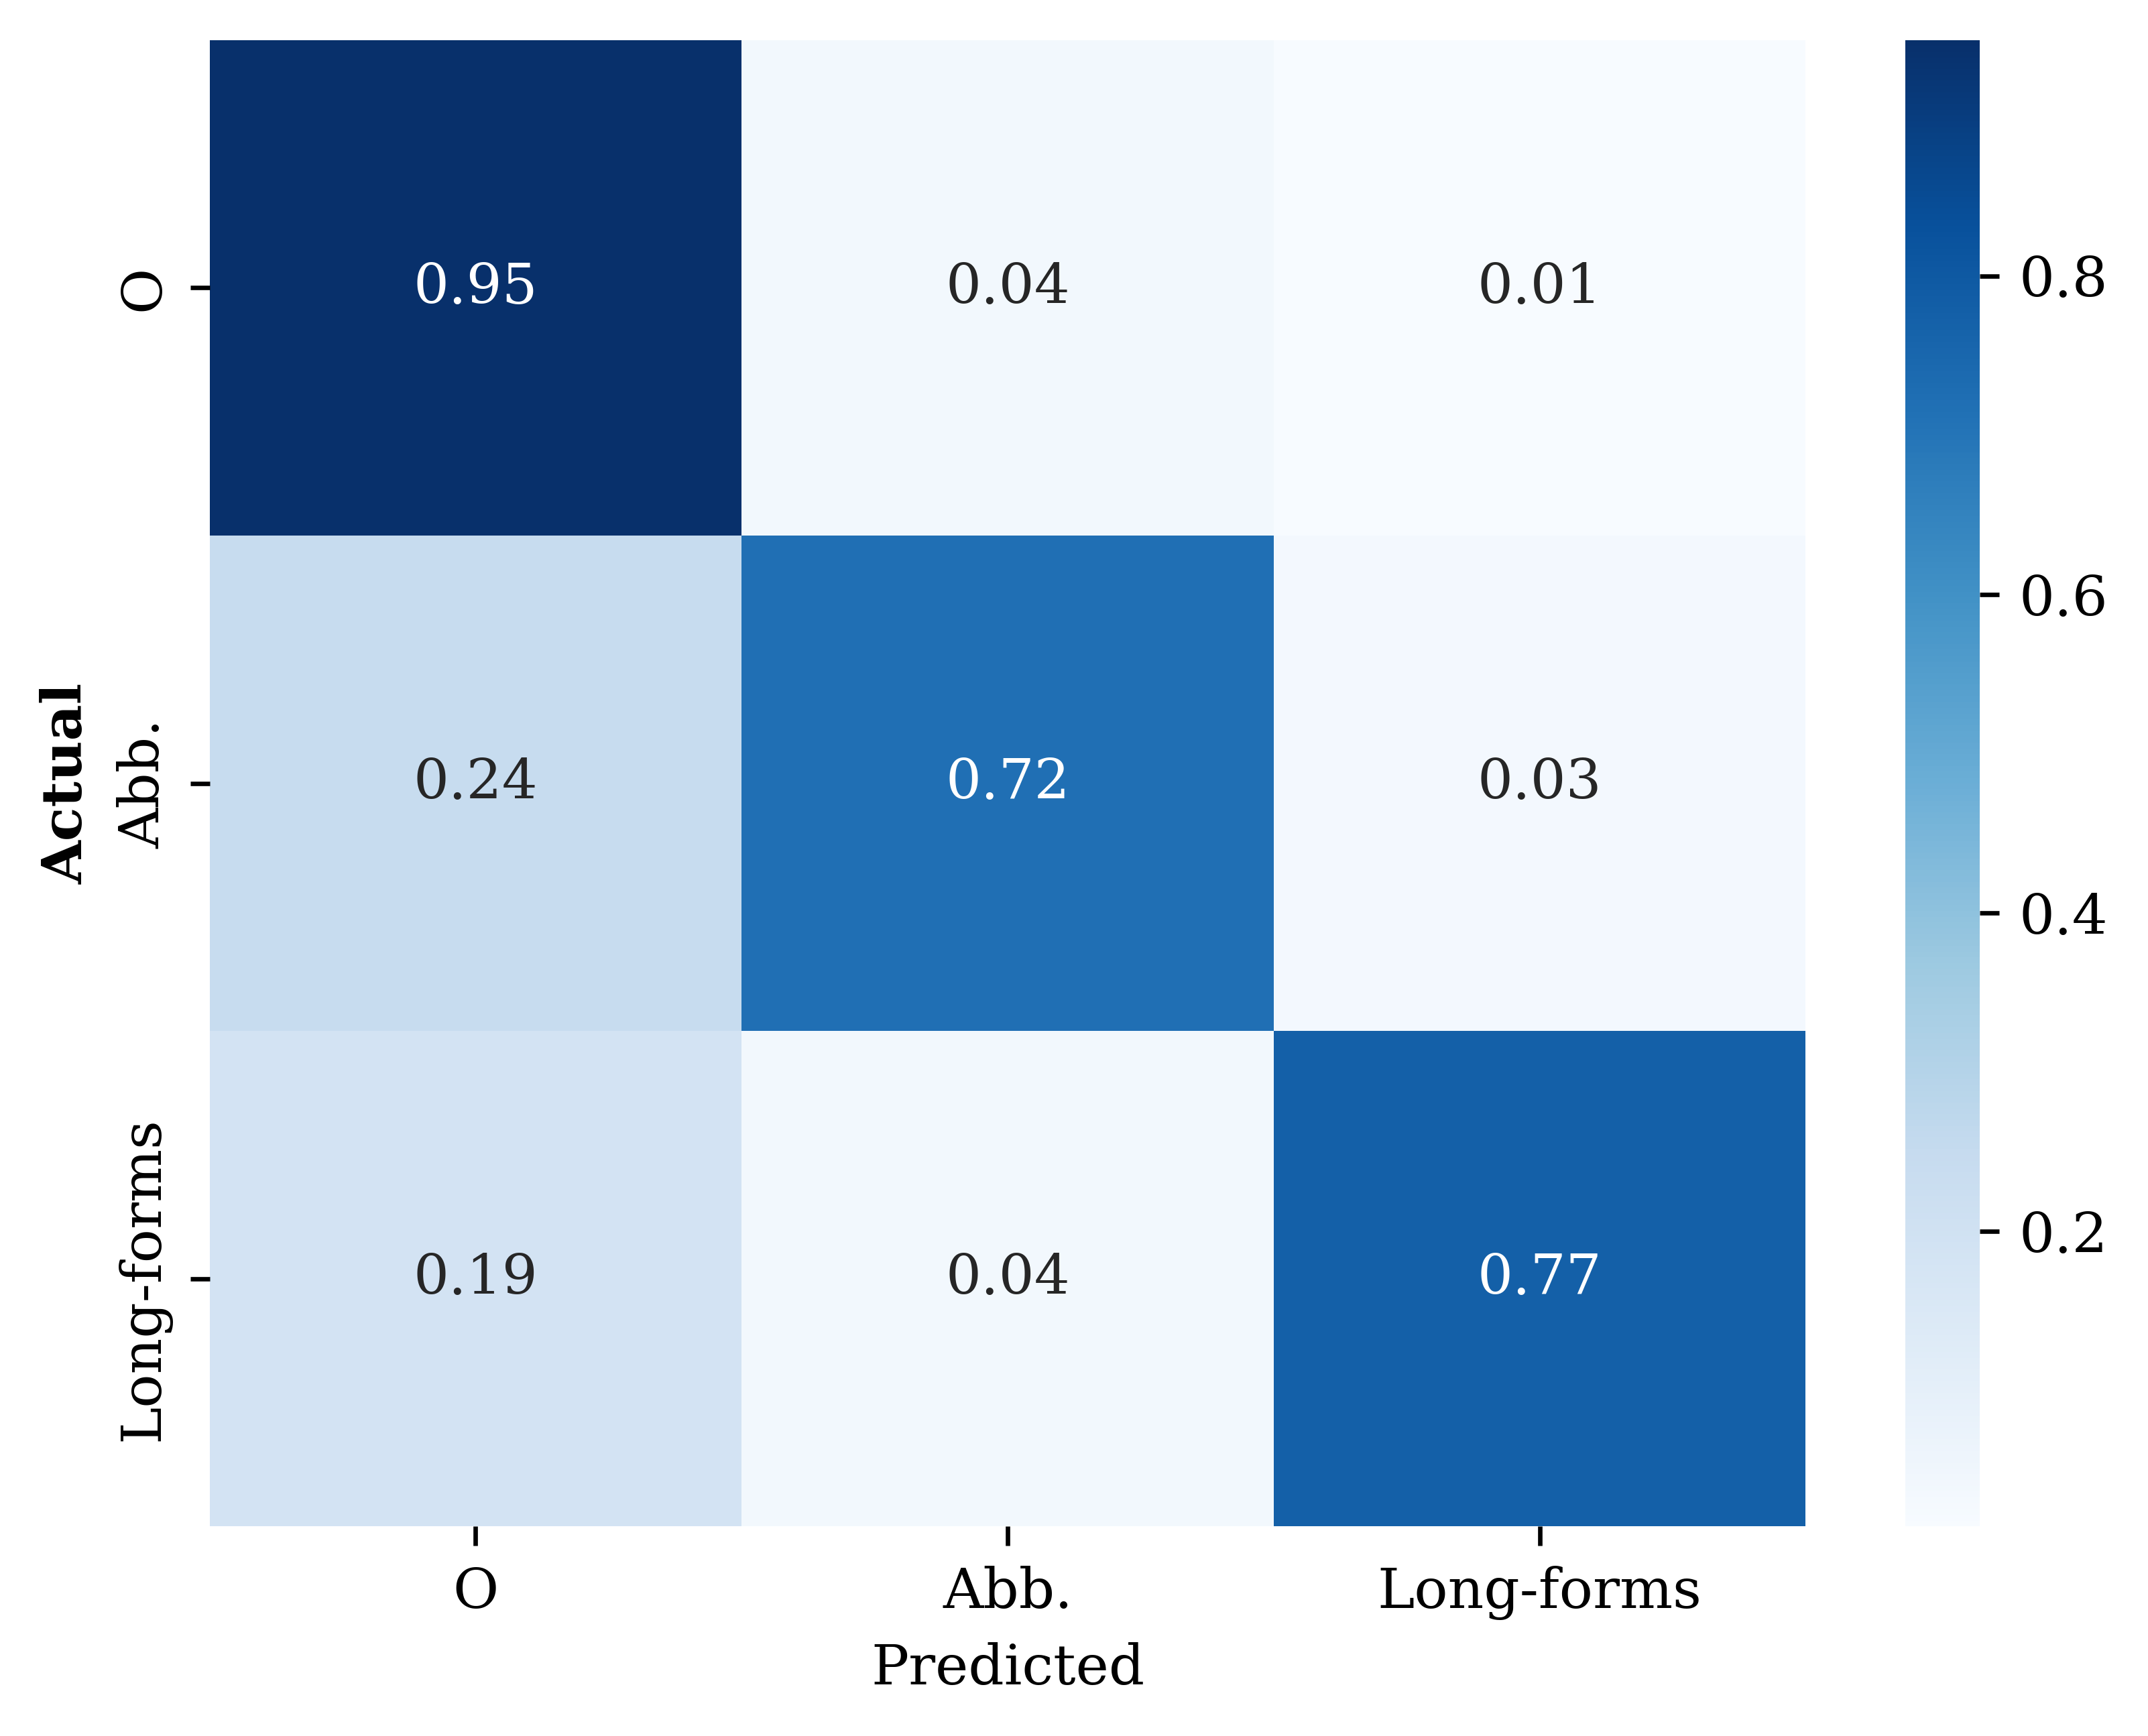

In [127]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ['B-O', 'B-AC', 'B-LF']
nlabels = ['O', 'Abb.', 'Long-forms']

cm = confusion_matrix(c, p, normalize='true', labels =labels)

plt.style.use('default')
plt.rcParams['text.usetex'] = False

plt.figure(dpi=600)

# change font to scientific
plt.rcParams['font.family'] = 'serif'

sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=nlabels, yticklabels=nlabels, fmt=".2f")
#make labels bold
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted')
plt.show()

In [117]:
from colorama import Back, Style

def vizu(words, output, truth):
    if isinstance(output, torch.Tensor):
        output = output.squeeze().tolist()
    col = {0: Back.GREEN, 1: Back.RED, 2: Back.BLACK, 3: Back.BLUE, 4: Back.MAGENTA}
    colors1 = [col[i] for i in output]
    colors2 = [col[i] for i in truth]
    words = [word.replace("Ġ", "") for word in words]
    print(Style.RESET_ALL + "Output:")
    for i, word in enumerate(words):
        print(colors1[i] + word, end=" ")
    print(Style.RESET_ALL + "\nTruth:")
    for i, word in enumerate(words):
        print(colors2[i] + word, end=" ")